In [195]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re as re
from datetime import date
from pandas_profiling import ProfileReport

In [196]:
def category_crosstab(category, target, dataframe):
    df = pd.crosstab(dataframe[target], dataframe[category], normalize='columns').transpose().sort_values(by=0, ascending=False)
    
    return df

def kmeans_clusterer(category, target, dataframe, validation_dataframe, k_clusters = 0, colors = 'rainbow'):
    import matplotlib.pyplot as plt
    from kneed import KneeLocator
    from sklearn.cluster import KMeans
    from sklearn.metrics import silhouette_score
    from sklearn.preprocessing import StandardScaler

    
    columns= [category, target]
    cluster_data = dataframe[columns]
    
    conditional_probability = category_crosstab(category, target, cluster_data)
    cluster_data['conditional_probability'] = cluster_data[category].apply(lambda x: conditional_probability.loc[x][1])
    
    cluster_data['Income_count']=cluster_data['Income'].copy()
    
    clustering_data = cluster_data.groupby(category).agg({'Income':'sum',
                                                          'Income_count':'count',
                                                          'conditional_probability':'first'}).sort_values(by='Income_count')
    clustering_data
    
    
    scaler = StandardScaler()
    scaled_features = scaler.fit_transform(clustering_data)

    kmeans_kwargs = {
    "init": "random",
    "n_init": 10,
    "max_iter": 1500,
    "random_state": 42,
        }

    # A list holds the SSE values for each k
    sse = []
    
    number_unique_categories = len(dataframe[category].unique())
    if number_unique_categories > 10: 
        max_number_clusters = 11
    else:
        max_number_clusters = number_unique_categories

    for k in range(1, max_number_clusters):
        kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
        kmeans.fit(scaled_features)
        sse.append(kmeans.inertia_)
    
  
    # Define Elbow point

    kl = KneeLocator(range(1, max_number_clusters), 
                     sse, 
                     curve="convex", 
                     direction="decreasing")
    
    if k_clusters == 0 : 
        number_cluster = kl.elbow
    else: 
        number_cluster = k_clusters
    
    # Run k means 
    
    kmeans= KMeans(n_clusters=number_cluster, **kmeans_kwargs)
    kmeans.fit(scaled_features)
    
    # assign kmeans labels to each category
    clustering_data['kmeans_cluster'] = kmeans.labels_
    
    
    # plot SSE (inertia) vs number of clusters - Improve
    plt.style.use('dark_background')
    plt.style.use('dark_background')
    fig, axes = plt.subplots(3,1,figsize=(10,20))
    fig.suptitle(category, fontsize=16)
    
        # first plot - inertia vs number of clusters
        
    x = range(1, max_number_clusters)
    y = sse
    #plt.style.use("fivethirtyeight")
    axes[0].plot(x, sse, marker = "D" )
    plt.sca(axes[0])
    plt.set_cmap(colors)
    plt.title('Inertia vs Number of Clusters')
    plt.xticks(range(1, max_number_clusters))
    plt.xlabel("Number of Clusters")
    plt.ylabel("SSE")
    plt.plot(x[number_cluster -1], y[number_cluster -1], 'ro')
    
        # second plot - number of individuals in class vs conditional probability
    
    sns.scatterplot(x='Income_count', 
                    y='conditional_probability', 
                    hue = 'kmeans_cluster' , 
                    data = clustering_data,
                    palette = colors,
                    ax = axes[1])
    
    plt.sca(axes[1])
    plt.title('Number of individuals in Category vs Conditional Probability')
    #plt.xticks(range(0, 100))
    # Set x-axis label
    plt.xlabel('Number of individuals in Category')
    # Set y-axis label
    plt.ylabel('Conditional Probability')
    
        # third plot - number of individuals in class that hit target vs conditional probability

    sns.scatterplot(x='Income', 
                    y='conditional_probability', 
                    hue = 'kmeans_cluster' , 
                    data = clustering_data,
                    palette = colors,
                    ax = axes[2])
    
    plt.sca(axes[2])
    plt.title('Number of individuals in Category w/ Target vs Conditional Probability')
    #plt.xticks(range(0, 100))
    # Set x-axis label
    plt.xlabel('Number of individuals in Category')
    # Set y-axis label
    plt.ylabel('Conditional Probability')
    
    #3d plotting 
    
    fig = plt.figure()
    fig.suptitle(category, fontsize=16)
    ax = plt.axes(projection='3d')
    
    # Data for three-dimensional scattered points
    zdata = clustering_data['conditional_probability']
    xdata = clustering_data['Income']
    ydata = clustering_data['Income_count']
    ax.scatter3D(xdata, ydata, zdata, c=clustering_data['kmeans_cluster'])#, cmap=colors);
    ax.set_xlabel('People in Category')
    ax.set_ylabel('People in Category w/target')
    ax.set_zlabel('Conditional Probability');
    
    
    display(clustering_data.sort_values(by='kmeans_cluster'))
    # Add cluster as dimension 
    new_category= category +' - Clustered'
    dataframe[new_category] = dataframe[category].apply(lambda x: clustering_data['kmeans_cluster'][x])
    validation_dataframe[new_category] = validation_dataframe[category].apply(lambda x: clustering_data['kmeans_cluster'][x])
    

    print('Process done')
    return kmeans

In [197]:
def simple_kmeans(clustering_data, max_k =10, k_clusters = 'else', visualize = True):
    import matplotlib.pyplot as plt
    from kneed import KneeLocator
    from sklearn.cluster import KMeans
    from sklearn.metrics import silhouette_score
    from sklearn.preprocessing import StandardScaler

    
    scaler = StandardScaler()
    scaled_features = scaler.fit_transform(clustering_data)
    scaled_df = pd.DataFrame(scaled_features)
    scaled_df.columns = clustering_data.columns

    kmeans_kwargs = {
    "init": "random",
    "n_init": 10,
    "max_iter": 1500,
    "random_state": 42,
        }

    # A list holds the SSE values for each k
    sse = []
    
    # Measuring SSE for different k cluster levels
    max_number_clusters = max_k
    
    
    for k in range(1, max_number_clusters):
        kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
        kmeans.fit(scaled_features)
        sse.append(kmeans.inertia_)
        
        # Define Elbow point Automatically or manually. 

    kl = KneeLocator(range(1, max_number_clusters), 
                     sse, 
                     curve="convex", 
                     direction="decreasing")
    
    
    if k_clusters == 'else' : 
        number_cluster = kl.elbow
    else: 
        number_cluster = k_clusters
    
    if visualize == True:
    
        # plot SSE (inertia) vs number of clusters - Improve

        plt.style.use('fivethirtyeight') # set dark style, 'cause its simply better. 
        #plt.set_cmap('Set1')

        fig, axes = plt.subplots(1,1,figsize=(10,20)) #3 subplots, each with its row
        #fig.suptitle(category, fontsize=16)

            # first plot - inertia vs number of clusters

        x = range(1, max_number_clusters)
        y = sse
        #plt.style.use("fivethirtyeight")
        axes.plot(x, sse )

        plt.sca(axes) # select ax0 
        #plt.set_cmap(colors)

        plt.title('Inertia vs Number of Clusters') #title
        plt.xticks(range(1, max_number_clusters)) # xticks
        plt.xlabel("Number of Clusters") # xlabels
        plt.ylabel("SSE") # ylabels
        plt.plot(x[number_cluster -1], y[number_cluster -1], color='green', marker='X', 
                 linestyle='dashed', linewidth=15, markersize=25) # show that represents 

    
    
    # Run k means with right number of clusters 
    
    kmeans= KMeans(n_clusters=number_cluster, **kmeans_kwargs)
    kmeans.fit(scaled_features)
    
    # assign kmeans labels to each category
    clustering_data['kmeans_cluster'] = kmeans.labels_
    scaled_df['kmeans_cluster'] = kmeans.labels_
    
    display(clustering_data.sort_values(by='kmeans_cluster'))
    
    return scaled_df

def boxplot_cluster_compparisson(dataframe):

    variables = dataframe.iloc[:,:-1].columns
    number_variables = len(variables)
    height = number_variables*20

    fig, ax = plt.subplots(number_variables,1, figsize =(height,height))

    for variable, x in zip(variables, range(number_variables)): 
        sns.boxplot(x= dataframe.iloc[:,-1] ,
                    y = dataframe[variable],
                       ax = ax[x])     
    return fig

def kmeans_analysis(clustering_data, max_k =10, k_clusters = 'else', visualize = True):
    
    sc_df = simple_kmeans(clustering_data, max_k =10, k_clusters = 'else', visualize = True)
    graphs = boxplot_cluster_compparisson(sc_df)
    return graphs, sc_df

In [198]:
def plot_cumulative_significance_PCA(pca, plotTitle):
    """Takes the PCA model after fit and transform, plotting the cumulative significance of each component"""

    # figure and axes
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    # draw plots
    ax1.plot(pca.explained_variance_, marker=".", markersize=12)
    ax2.plot(pca.explained_variance_ratio_, marker=".", markersize=12, label="Proportion")
    ax2.plot(np.cumsum(pca.explained_variance_ratio_), marker=".", markersize=12, linestyle="--", label="Cumulative")

    # customizations
    ax2.legend()
    ax1.set_title(plotTitle, fontsize=14)
    ax2.set_title("Variance Explained", fontsize=14)
    ax1.set_ylabel("Eigenvalue")
    ax2.set_ylabel("Proportion")
    ax1.set_xlabel("Components")
    ax2.set_xlabel("Components")
    ax1.set_xticks(range(0, pca.n_components_, 2))
    ax1.set_xticklabels(range(1, pca.n_components_ + 1, 2))
    ax2.set_xticks(range(0, pca.n_components_, 2))
    ax2.set_xticklabels(range(1, pca.n_components_ + 1, 2))

    plt.show()

In [199]:
def pca_analysis(subgroups_pca_dic, path_to_excel):
   # writer = pd.ExcelWriter('/Files/test_pca.xlsx')

    for subGroup in hood_subgroups_pca_dic.keys():
        columns = hood_subgroups_dic[subGroup]
        k = hood_subgroups_pca_dic[subGroup]

        #PCA fit
        pca = PCA(n_components=k)
        pca_feat = pca.fit_transform(pca_data[columns])

        #Creating dataframe
        pca_feat_names = [f"PC{i}" for i in range(k)]
        pca_df = pd.DataFrame(pca_feat, index=pca_data[columns].index, columns=pca_feat_names)

        # Reassigning df to contain pca variables
        pca_df = pd.concat([pca_data[columns], pca_df], axis=1)

        # Interpreting each Principal Component
        loadings = pca_df[columns + pca_feat_names].corr().loc[columns, pca_feat_names]
        print("\n\n\n//////////////////////////////////%s" % subGroup)
        display(loadings.style.applymap(_color_red_or_green))

        # Returning an excel file (sorry) with the analysis

        test='home_structures'

        loadings.style.applymap(_color_red_or_green).to_excel(writer, subGroup)
        #writer.save()

In [200]:
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_row', 500)

# 0. Loading our Data

In [201]:
df = pd.read_csv('Data/donors.csv')

C:\Users\josem\.conda\envs\python-standard\lib\site-packages\IPython\core\interactiveshell.py:3146: DtypeWarning: Columns (9,412) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [202]:
df.head()

Unnamed: 0     ODATEDW OSOURCE  TCODE STATE    ZIP MAILCODE PVASTATE  \
0           0  2009-01-01     GRI      0    IL  61081                     
1           1  2014-01-01     BOA      1    CA  91326                     
2           2  2010-01-01     AMH      1    NC  27017                     
3           3  2007-01-01     BRY      0    CA  95953                     
4           4  2006-01-01              0    FL  33176                     

          DOB NOEXCH RECINHSE RECP3 RECPGVG RECSWEEP MDMAUD DOMAIN HOMEOWNR  \
0  1957-12-01      0                                   XXXX     T2            
1  1972-02-01      0                                   XXXX     S1        H   
2         NaN      0                                   XXXX     R2        U   
3  1948-01-01      0                                   XXXX     R2        U   
4  1940-01-01      0        X     X                    XXXX     S2        H   

  CHILD03 CHILD07 CHILD12 CHILD18  NUMCHLD  INCOME GENDER  WEALTH1  HIT  \
0                                      NaN     NaN      F      NaN    0   
1                               M      1.0     6.0      M      9.0   16   
2                                      NaN     3.0      M      1.0    2   
3                                      NaN     1.0      F      4.0    2   
4                                      1.0     3.0      F      2.0   60   

   MBCRAFT  MBGARDEN  MBBOOKS  MBCOLECT  MAGFAML  MAGFEM  MAGMALE  PUBGARDN  \
0      NaN       NaN      NaN       NaN      NaN     NaN      NaN       NaN   
1      0.0       0.0      3.0       1.0      1.0     1.0      0.0       0.0   
2      0.0       0.0      1.0       0.0      0.0     0.0      0.0       0.0   
3      0.0       0.0      0.0       0.0      0.0     0.0      0.0       0.0   
4      1.0       0.0      9.0       0.0      4.0     1.0      0.0       0.0   

   PUBCULIN  PUBHLTH  PUBDOITY  PUBNEWFN  PUBPHOTO  PUBOPP DATASRCE  MALEMILI  \
0       NaN      NaN       NaN       NaN       NaN     NaN                  0   
1       0.0      2.0       0.0       3.0       0.0     0.0        3         0   
2       0.0      1.0       0.0       0.0       0.0     0.0        3         0   
3       0.0      0.0       0.0       0.0       0.0     1.0        3         0   
4       0.0      4.0       0.0       1.0       0.0     1.0        3         1   

   MALEVET  VIETVETS  WWIIVETS  LOCALGOV  STATEGOV  FEDGOV SOLP3 SOLIH MAJOR  \
0       39        34        18        10         2       1                     
1       15        55        11         6         2       1                     
2       20        29        33         6         8       1                     
3       23        14        31         3         0       3                     
4       28         9        53        26         3       2          12         

   WEALTH2 GEOCODE COLLECT1 VETERANS BIBLE CATLG HOMEE PETS CDPLAY STEREO  \
0      5.0                                                                  
1      9.0      02                                                          
2      1.0                                                                  
3      0.0                                                                  
4      NaN                               Y     Y                        Y   

  PCOWNERS PHOTO CRAFTS FISHER GARDENIN BOATS WALKER KIDSTUFF CARDS PLATES  \
0                                                                            
1                                                                            
2                                                                            
3                                                                            
4                     Y               Y            Y              Y          

  LIFESRC PEPSTRFL  POP901  POP902  POP903  POP90C1  POP90C2  POP90C3  \
0                X     992     264     332        0       35       65   
1                     3611     940     998       99        0        0   
2                X    7001    20

# 1.Analysing Data

 ## Donation history

- RAMNTALL  -->  Dollar amount of lifetime gifts to date
- NGIFTALL  -->  Number of lifetime gifts to date
- AVGGIFT  -->   Average dollar amount of gifts to date
- NUMPROM  -->   Lifetime number of promotions received to date

### Data to generate/keep
- AVGGIFT - Average donated amount
- NGIFTALL / NUMPROM - Success percentage

In [203]:
columns_source = [
    'RAMNTALL',
    'NGIFTALL',
    'AVGGIFT',
    'NUMPROM'
]

filtered_df = df[['AVGGIFT']].copy()

In [204]:
scaler = StandardScaler()

np.var(scaler.fit_transform(df[['AVGGIFT']]))

#df[columns_source].head()

1.0

In [205]:
df[columns_source].isna().sum()

RAMNTALL    0
NGIFTALL    0
AVGGIFT     0
NUMPROM     0
dtype: int64

In [206]:
# Make sure datatype is correct
df[columns_source].dtypes

RAMNTALL    float64
NGIFTALL      int64
AVGGIFT     float64
NUMPROM       int64
dtype: object

In [207]:
#fix dtypes
df['RAMNTALL'] = df['RAMNTALL'].astype('int64')

In [208]:
df[columns_source].head()

RAMNTALL  NGIFTALL    AVGGIFT  NUMPROM
0       240        31   7.741935       74
1        47         3  15.666667       32
2       202        27   7.481481       63
3       109        16   6.812500       66
4       254        37   6.864865      113

In [209]:
# NGIFTALL / NUMPROM - Success percentage
filtered_df['SUCCESS_PCT'] = df['NGIFTALL'] / df['NUMPROM']
filtered_df['SUCCESS_PCT'].head()

0    0.418919
1    0.093750
2    0.428571
3    0.242424
4    0.327434
Name: SUCCESS_PCT, dtype: float64

## Adding columns

- Percentage of time as each-category
- Variance on donation value

#### Percentage of time as each-category

In [210]:
def get_percentage_as_category(source_dataframe, target_df, category):
    re_expression = re.compile('^RFA_\d{1,2}$')

    rfa_columns = [column for column in source_dataframe.columns.values if re_expression.match(column)]

    rfas = source_dataframe[rfa_columns].copy()

    rfas = rfas.applymap(lambda val: 1 if val[0] == category else 0)

    target_df['PCT_TIME_LAPSED_%s' % category] =  rfas.sum(axis=1) / df['NUMPROM']

    return target_df

In [211]:
filtered_df= get_percentage_as_category(df, filtered_df, 'F')
filtered_df.head()

AVGGIFT  SUCCESS_PCT  PCT_TIME_LAPSED_F
0   7.741935     0.418919            0.00000
1  15.666667     0.093750            0.03125
2   7.481481     0.428571            0.00000
3   6.812500     0.242424            0.00000
4   6.864865     0.327434            0.00000

In [212]:
filtered_df= get_percentage_as_category(df, filtered_df, 'N')
filtered_df.head()

AVGGIFT  SUCCESS_PCT  PCT_TIME_LAPSED_F  PCT_TIME_LAPSED_N
0   7.741935     0.418919            0.00000              0.000
1  15.666667     0.093750            0.03125              0.125
2   7.481481     0.428571            0.00000              0.000
3   6.812500     0.242424            0.00000              0.000
4   6.864865     0.327434            0.00000              0.000

In [213]:
filtered_df= get_percentage_as_category(df, filtered_df, 'A')
filtered_df.head()

AVGGIFT  SUCCESS_PCT  PCT_TIME_LAPSED_F  PCT_TIME_LAPSED_N  \
0   7.741935     0.418919            0.00000              0.000   
1  15.666667     0.093750            0.03125              0.125   
2   7.481481     0.428571            0.00000              0.000   
3   6.812500     0.242424            0.00000              0.000   
4   6.864865     0.327434            0.00000              0.000   

   PCT_TIME_LAPSED_A  
0           0.000000  
1           0.312500  
2           0.000000  
3           0.060606  
4           0.132743

In [214]:
filtered_df= get_percentage_as_category(df, filtered_df, 'L')
filtered_df.head()

AVGGIFT  SUCCESS_PCT  PCT_TIME_LAPSED_F  PCT_TIME_LAPSED_N  \
0   7.741935     0.418919            0.00000              0.000   
1  15.666667     0.093750            0.03125              0.125   
2   7.481481     0.428571            0.00000              0.000   
3   6.812500     0.242424            0.00000              0.000   
4   6.864865     0.327434            0.00000              0.000   

   PCT_TIME_LAPSED_A  PCT_TIME_LAPSED_L  
0           0.000000           0.013514  
1           0.312500           0.062500  
2           0.000000           0.015873  
3           0.060606           0.015152  
4           0.132743           0.044248

In [215]:
filtered_df= get_percentage_as_category(df, filtered_df, 'I')
filtered_df.head()

AVGGIFT  SUCCESS_PCT  PCT_TIME_LAPSED_F  PCT_TIME_LAPSED_N  \
0   7.741935     0.418919            0.00000              0.000   
1  15.666667     0.093750            0.03125              0.125   
2   7.481481     0.428571            0.00000              0.000   
3   6.812500     0.242424            0.00000              0.000   
4   6.864865     0.327434            0.00000              0.000   

   PCT_TIME_LAPSED_A  PCT_TIME_LAPSED_L  PCT_TIME_LAPSED_I  
0           0.000000           0.013514           0.000000  
1           0.312500           0.062500           0.000000  
2           0.000000           0.015873           0.000000  
3           0.060606           0.015152           0.000000  
4           0.132743           0.044248           0.017699

In [216]:
filtered_df= get_percentage_as_category(df, filtered_df, 'S')
filtered_df.head()

AVGGIFT  SUCCESS_PCT  PCT_TIME_LAPSED_F  PCT_TIME_LAPSED_N  \
0   7.741935     0.418919            0.00000              0.000   
1  15.666667     0.093750            0.03125              0.125   
2   7.481481     0.428571            0.00000              0.000   
3   6.812500     0.242424            0.00000              0.000   
4   6.864865     0.327434            0.00000              0.000   

   PCT_TIME_LAPSED_A  PCT_TIME_LAPSED_L  PCT_TIME_LAPSED_I  PCT_TIME_LAPSED_S  
0           0.000000           0.013514           0.000000           0.297297  
1           0.312500           0.062500           0.000000           0.000000  
2           0.000000           0.015873           0.000000           0.285714  
3           0.060606           0.015152           0.000000           0.227273  
4           0.132743           0.044248           0.017699           0.000000

#### Variance on donation value

In [217]:
re_expression = re.compile('^RAMNT_\d{1,2}$')

ramt_columns = [column for column in df.columns.values if re_expression.match(column)]
ramt_columns[:3]

['RAMNT_3', 'RAMNT_4', 'RAMNT_5']

In [218]:
ramts = df[ramt_columns].copy()
ramts.head()

RAMNT_3  RAMNT_4  RAMNT_5  RAMNT_6  RAMNT_7  RAMNT_8  RAMNT_9  RAMNT_10  \
0      NaN      NaN      NaN      NaN      NaN      NaN      NaN      10.0   
1      NaN      NaN      NaN      NaN      NaN      NaN     25.0       NaN   
2      NaN      NaN      NaN      NaN      NaN      NaN      NaN       NaN   
3      NaN      NaN      NaN      NaN      NaN      NaN      NaN       NaN   
4      NaN      NaN      NaN      NaN      NaN     15.0      NaN       NaN   

   RAMNT_11  RAMNT_12  RAMNT_13  RAMNT_14  RAMNT_15  RAMNT_16  RAMNT_17  \
0       NaN       NaN       NaN      10.0      11.0      11.0      11.0   
1       NaN       NaN       NaN       NaN       NaN      12.0       NaN   
2       NaN      11.0       NaN       9.0       NaN       9.0       NaN   
3      10.0      10.0       NaN      10.0       NaN       7.0      11.0   
4       NaN       NaN       NaN      10.0       NaN       NaN       NaN   

   RAMNT_18  RAMNT_19  RAMNT_20  RAMNT_21  RAMNT_22  RAMNT_23  RAMNT_24  
0       NaN       NaN       NaN       NaN       NaN      11.0       9.0  
1       NaN       NaN       NaN       NaN       NaN       NaN       NaN  
2       8.0       NaN       NaN       NaN       8.0       7.0       6.0  
3       NaN       NaN       6.0      11.0       NaN       NaN       NaN  
4       NaN       NaN       NaN       NaN       NaN       NaN       NaN

In [219]:
filtered_df['GIFT_VAR'] = ramts.var(axis=1)
filtered_df['GIFT_VAR'].fillna(0, inplace=True)
filtered_df.head()

AVGGIFT  SUCCESS_PCT  PCT_TIME_LAPSED_F  PCT_TIME_LAPSED_N  \
0   7.741935     0.418919            0.00000              0.000   
1  15.666667     0.093750            0.03125              0.125   
2   7.481481     0.428571            0.00000              0.000   
3   6.812500     0.242424            0.00000              0.000   
4   6.864865     0.327434            0.00000              0.000   

   PCT_TIME_LAPSED_A  PCT_TIME_LAPSED_L  PCT_TIME_LAPSED_I  PCT_TIME_LAPSED_S  \
0           0.000000           0.013514           0.000000           0.297297   
1           0.312500           0.062500           0.000000           0.000000   
2           0.000000           0.015873           0.000000           0.285714   
3           0.060606           0.015152           0.000000           0.227273   
4           0.132743           0.044248           0.017699           0.000000   

    GIFT_VAR  
0   0.619048  
1  84.500000  
2   2.571429  
3   3.904762  
4  12.500000

## Correlation check on filtered columns so far

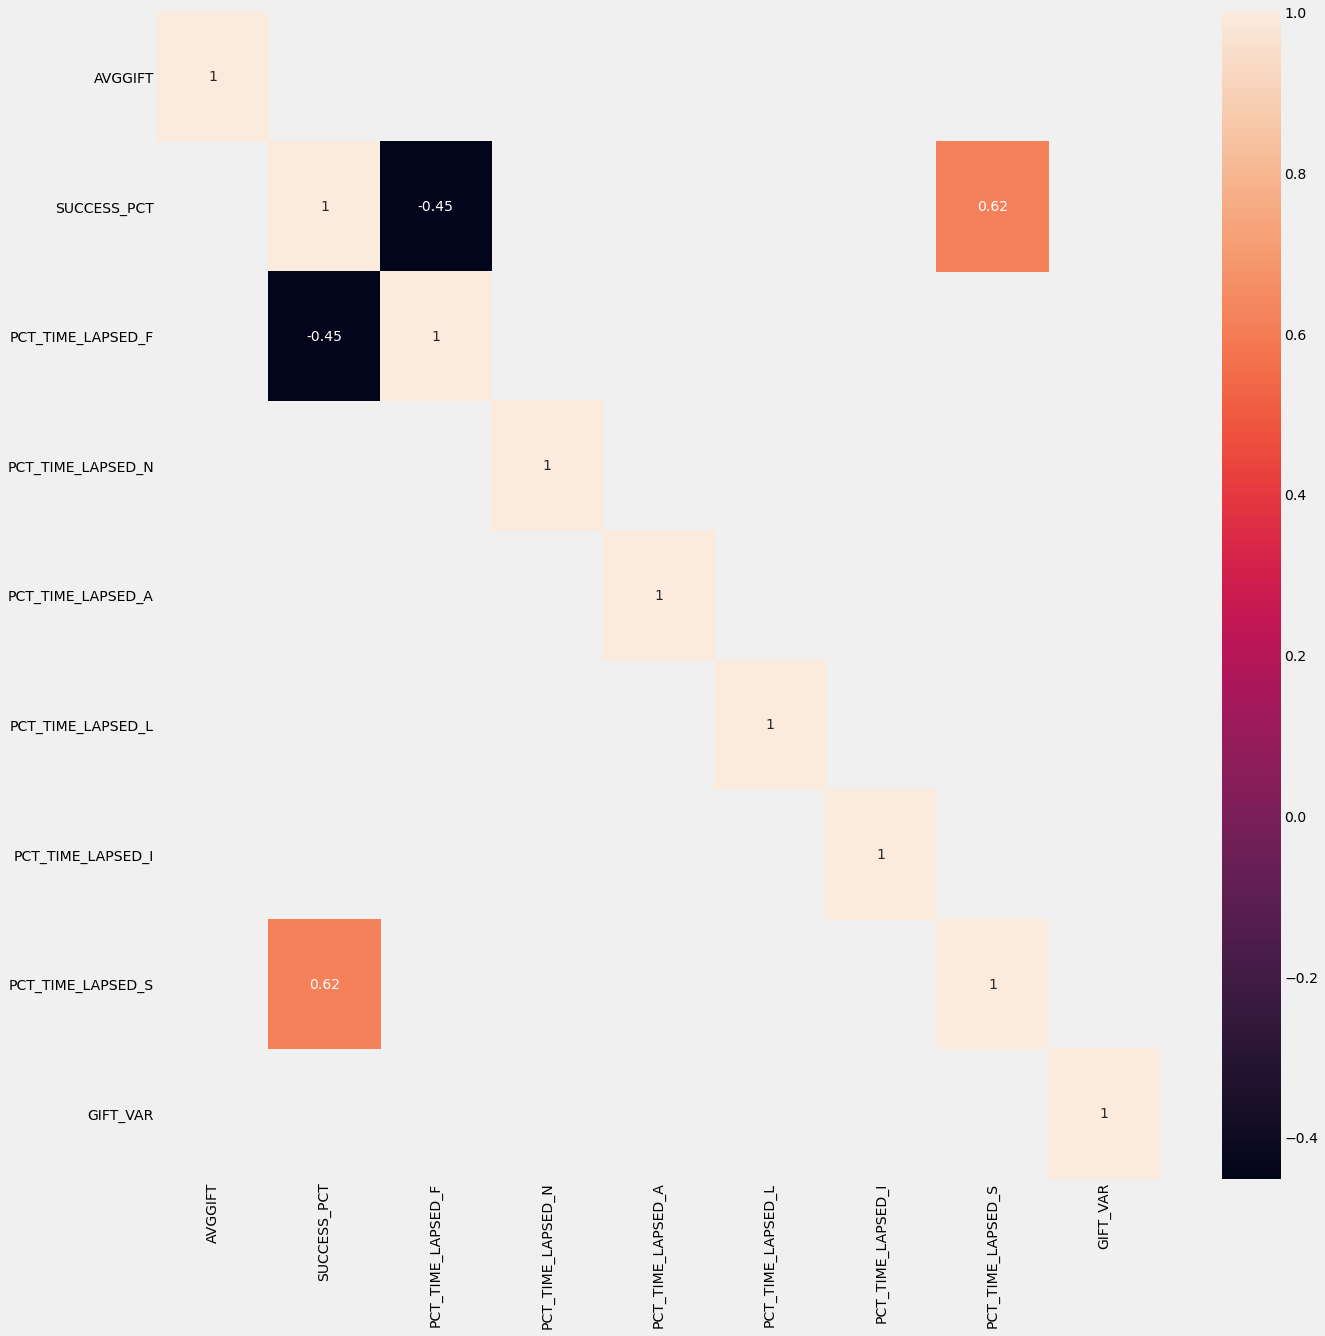

In [220]:
corr = filtered_df.corr()
corr = corr[np.abs(corr) > 0.45]


plt.figure(figsize=(20,20))
sns.heatmap(corr, annot=True)
plt.show()

## Analysing Interests columns

In [221]:
columns_interests= [
    'COLLECT1',
    'VETERANS',
    'BIBLE',
    'CATLG',
    'HOMEE',
    'PETS',
    'CDPLAY',
    'STEREO',
    'PCOWNERS',
    'PHOTO',
    'CRAFTS',
    'FISHER',
    'GARDENIN',
    'BOATS',
    'WALKER',
    'KIDSTUFF',
    'CARDS',
    'PLATES'
]

In [222]:
interests_df = df[columns_interests].copy()
interests_df.head()

COLLECT1 VETERANS BIBLE CATLG HOMEE PETS CDPLAY STEREO PCOWNERS PHOTO  \
0                                                                         
1                                                                         
2                                                                         
3                                                                         
4                       Y     Y                        Y                  

  CRAFTS FISHER GARDENIN BOATS WALKER KIDSTUFF CARDS PLATES  
0                                                            
1                                                            
2                                                            
3                                                            
4      Y               Y            Y              Y

In [223]:
interests_df = interests_df.applymap(lambda val: 1 if val == 'Y' else 0)
interests_df.head()

COLLECT1  VETERANS  BIBLE  CATLG  HOMEE  PETS  CDPLAY  STEREO  PCOWNERS  \
0         0         0      0      0      0     0       0       0         0   
1         0         0      0      0      0     0       0       0         0   
2         0         0      0      0      0     0       0       0         0   
3         0         0      0      0      0     0       0       0         0   
4         0         0      1      1      0     0       0       1         0   

   PHOTO  CRAFTS  FISHER  GARDENIN  BOATS  WALKER  KIDSTUFF  CARDS  PLATES  
0      0       0       0         0      0       0         0      0       0  
1      0       0       0         0      0       0         0      0       0  
2      0       0       0         0      0       0         0      0       0  
3      0       0       0         0      0       0         0      0       0  
4      0       1       0         1      0       1         0      1       0

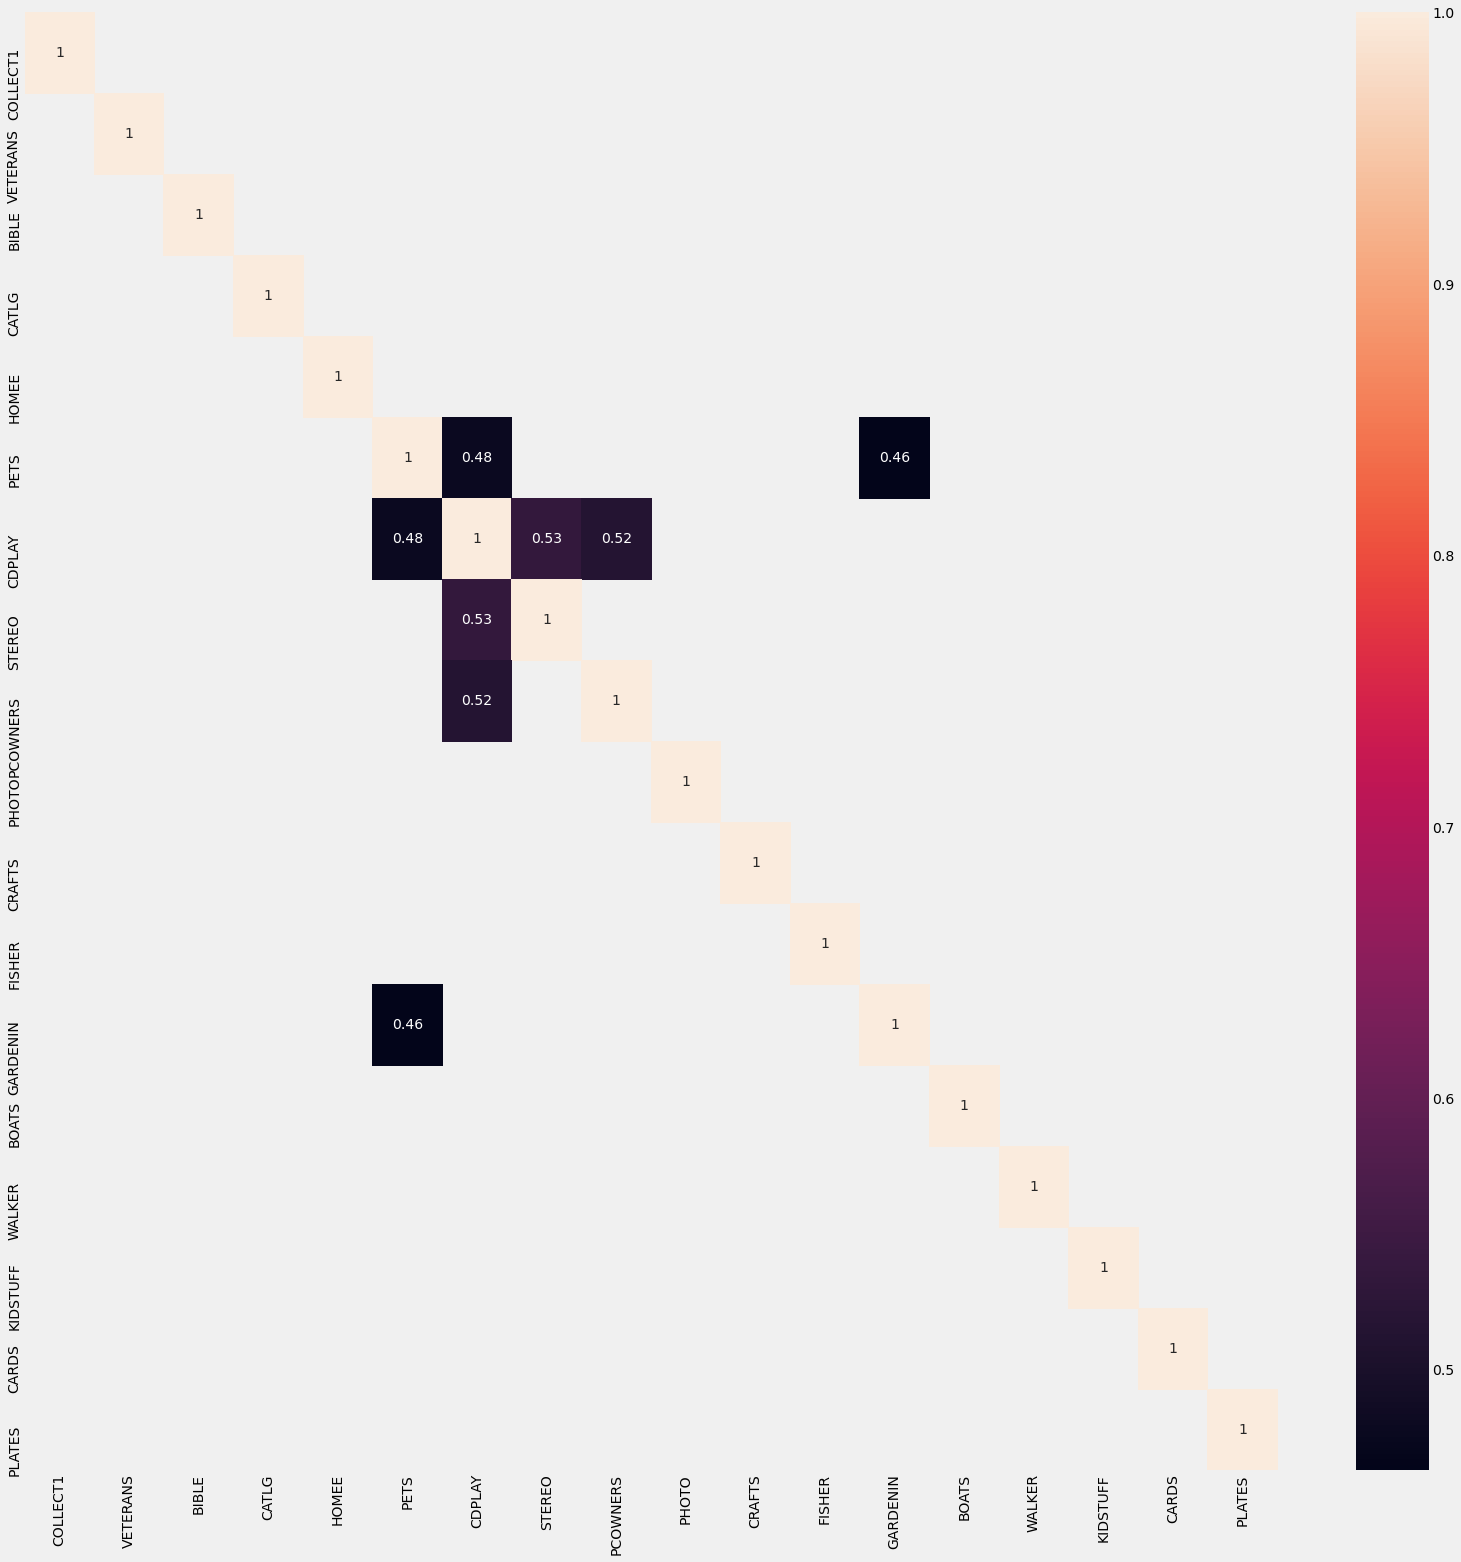

In [224]:
corr = interests_df.corr()
corr = corr[np.abs(corr) > 0.45]

plt.figure(figsize=(25,25))
sns.heatmap(corr, annot=True)
plt.show()

    low correlations, going to ignore for now since there's to many variables

## Analysing wealth columns

In [225]:
len(df)

95412

In [226]:
df['WEALTH1'].count(), df['WEALTH1'].isna().sum()

(50680, 44732)

In [227]:
df['WEALTH2'].count(), df['WEALTH2'].isna().sum()

(51589, 43823)

In [228]:
df.WEALTH1.max(), df.WEALTH1.min()

(9.0, 0.0)

In [229]:
df.WEALTH2.max(), df.WEALTH2.min()

(9.0, 0.0)

In [230]:
wealth_df = df[['WEALTH1','WEALTH2']].copy()

In [231]:
pct_non_NaN = wealth_df.mean(axis=1).count() / wealth_df.shape[0]
print('Percentage of columns with value after merge: %1.2f%%' % (pct_non_NaN *100))

Percentage of columns with value after merge: 77.11%


In [232]:
wealth_df['Merged'] = wealth_df.max(axis=1)
wealth_df.head()

WEALTH1  WEALTH2  Merged
0      NaN      5.0     5.0
1      9.0      9.0     9.0
2      1.0      1.0     1.0
3      4.0      0.0     4.0
4      2.0      NaN     2.0

In [233]:
filtered_df['WEALTH'] = wealth_df.Merged
filtered_df.dropna(subset=['WEALTH'], inplace=True)
del wealth_df

filtered_df.head()

AVGGIFT  SUCCESS_PCT  PCT_TIME_LAPSED_F  PCT_TIME_LAPSED_N  \
0   7.741935     0.418919            0.00000              0.000   
1  15.666667     0.093750            0.03125              0.125   
2   7.481481     0.428571            0.00000              0.000   
3   6.812500     0.242424            0.00000              0.000   
4   6.864865     0.327434            0.00000              0.000   

   PCT_TIME_LAPSED_A  PCT_TIME_LAPSED_L  PCT_TIME_LAPSED_I  PCT_TIME_LAPSED_S  \
0           0.000000           0.013514           0.000000           0.297297   
1           0.312500           0.062500           0.000000           0.000000   
2           0.000000           0.015873           0.000000           0.285714   
3           0.060606           0.015152           0.000000           0.227273   
4           0.132743           0.044248           0.017699           0.000000   

    GIFT_VAR  WEALTH  
0   0.619048     5.0  
1  84.500000     9.0  
2   2.571429     1.0  
3   3.904762     4.0  
4  12.500000     2.0

## Analysing other columns

In [234]:
other_df = df[['GENDER','INCOME','HOMEOWNR']].copy()
other_df.head()

GENDER  INCOME HOMEOWNR
0      F     NaN         
1      M     6.0        H
2      M     3.0        U
3      F     1.0        U
4      F     3.0        H

In [235]:
other_df.HOMEOWNR.replace(['',' '], 'U', inplace=True)
other_df.HOMEOWNR.replace(['U'], 0, inplace=True)
other_df.HOMEOWNR.replace(['H'], 1, inplace=True)

In [236]:
other_df.isna().sum()

GENDER          0
INCOME      21286
HOMEOWNR        0
dtype: int64

In [237]:
other_df.GENDER.replace(['A','C'],'J', inplace=True)
other_df.GENDER.replace(' ','U', inplace=True)
gender_dummies = pd.get_dummies(other_df.GENDER, prefix='GENDER')

In [238]:
other_df.drop(columns='GENDER', inplace=True)
other_df = other_df.join(gender_dummies)

In [239]:
filtered_df = pd.concat([filtered_df, other_df], axis=1)
filtered_df.dropna(subset=['INCOME'], inplace=True)
filtered_df.head()

AVGGIFT  SUCCESS_PCT  PCT_TIME_LAPSED_F  PCT_TIME_LAPSED_N  \
1  15.666667     0.093750            0.03125              0.125   
2   7.481481     0.428571            0.00000              0.000   
3   6.812500     0.242424            0.00000              0.000   
4   6.864865     0.327434            0.00000              0.000   
6   7.642857     0.222222            0.00000              0.000   

   PCT_TIME_LAPSED_A  PCT_TIME_LAPSED_L  PCT_TIME_LAPSED_I  PCT_TIME_LAPSED_S  \
1           0.312500           0.062500           0.000000           0.000000   
2           0.000000           0.015873           0.000000           0.285714   
3           0.060606           0.015152           0.000000           0.227273   
4           0.132743           0.044248           0.017699           0.000000   
6           0.126984           0.015873           0.000000           0.174603   

    GIFT_VAR  WEALTH  INCOME  HOMEOWNR  GENDER_F  GENDER_J  GENDER_M  GENDER_U  
1  84.500000     9.0     6.0         1         0         0         1         0  
2   2.571429     1.0     3.0         0         0         0         1         0  
3   3.904762     4.0     1.0         0         1         0         0         0  
4  12.500000     2.0     3.0         1         1         0         0         0  
6   0.500000     6.0     4.0         1         1         0         0         0

## Analysing Children columns

In [240]:
children_columns = [
    'CHILD03',
    'CHILD07',
    'CHILD12',
    'CHILD18',
    'NUMCHLD'
]

In [241]:
children_df = df[children_columns].copy()
children_df.head()

CHILD03 CHILD07 CHILD12 CHILD18  NUMCHLD
0                                      NaN
1                               M      1.0
2                                      NaN
3                                      NaN
4                                      1.0

In [242]:
children_df.replace(' ', 0, inplace=True)
children_df.replace('', 0, inplace=True)
children_df.replace(['M','F','B'], 1, inplace=True)
children_df.fillna(0, inplace=True)

children_df = children_df.astype('int64')
children_df.head()

CHILD03  CHILD07  CHILD12  CHILD18  NUMCHLD
0        0        0        0        0        0
1        0        0        0        1        1
2        0        0        0        0        0
3        0        0        0        0        0
4        0        0        0        0        1

In [243]:
children_df['SUM_ageGap_columns'] = children_df[children_columns[:-1]].sum(axis=1)
children_df.drop(columns=children_columns[:-1], inplace=True)

children_df.head()

NUMCHLD  SUM_ageGap_columns
0        0                   0
1        1                   1
2        0                   0
3        0                   0
4        1                   0

In [244]:
filtered_df['CHILDREN'] = children_df.max(axis=1)
filtered_df.head()

AVGGIFT  SUCCESS_PCT  PCT_TIME_LAPSED_F  PCT_TIME_LAPSED_N  \
1  15.666667     0.093750            0.03125              0.125   
2   7.481481     0.428571            0.00000              0.000   
3   6.812500     0.242424            0.00000              0.000   
4   6.864865     0.327434            0.00000              0.000   
6   7.642857     0.222222            0.00000              0.000   

   PCT_TIME_LAPSED_A  PCT_TIME_LAPSED_L  PCT_TIME_LAPSED_I  PCT_TIME_LAPSED_S  \
1           0.312500           0.062500           0.000000           0.000000   
2           0.000000           0.015873           0.000000           0.285714   
3           0.060606           0.015152           0.000000           0.227273   
4           0.132743           0.044248           0.017699           0.000000   
6           0.126984           0.015873           0.000000           0.174603   

    GIFT_VAR  WEALTH  INCOME  HOMEOWNR  GENDER_F  GENDER_J  GENDER_M  \
1  84.500000     9.0     6.0         1         0         0         1   
2   2.571429     1.0     3.0         0         0         0         1   
3   3.904762     4.0     1.0         0         1         0         0   
4  12.500000     2.0     3.0         1         1         0         0   
6   0.500000     6.0     4.0         1         1         0         0   

   GENDER_U  CHILDREN  
1         0         1  
2         0         0  
3         0         0  
4         0         1  
6         0         1

In [245]:
filtered_df.shape

(74126, 17)

## Adding Neighborhood Socio Economic Status

In [246]:
df['DOMAIN']

0        T2
1        S1
2        R2
3        R2
4        S2
         ..
95407    C2
95408    C1
95409    C3
95410    C1
95411    C1
Name: DOMAIN, Length: 95412, dtype: object

In [247]:
socio_economic_status = df['DOMAIN'].str[1]
socio_economic_status = pd.get_dummies(socio_economic_status, prefix='SES_')

socio_economic_status.head()

SES__1  SES__2  SES__3  SES__4
0       0       1       0       0
1       1       0       0       0
2       0       1       0       0
3       0       1       0       0
4       0       1       0       0

In [248]:
filtered_df = filtered_df.join(socio_economic_status, how='left')
filtered_df.head()

AVGGIFT  SUCCESS_PCT  PCT_TIME_LAPSED_F  PCT_TIME_LAPSED_N  \
1  15.666667     0.093750            0.03125              0.125   
2   7.481481     0.428571            0.00000              0.000   
3   6.812500     0.242424            0.00000              0.000   
4   6.864865     0.327434            0.00000              0.000   
6   7.642857     0.222222            0.00000              0.000   

   PCT_TIME_LAPSED_A  PCT_TIME_LAPSED_L  PCT_TIME_LAPSED_I  PCT_TIME_LAPSED_S  \
1           0.312500           0.062500           0.000000           0.000000   
2           0.000000           0.015873           0.000000           0.285714   
3           0.060606           0.015152           0.000000           0.227273   
4           0.132743           0.044248           0.017699           0.000000   
6           0.126984           0.015873           0.000000           0.174603   

    GIFT_VAR  WEALTH  INCOME  HOMEOWNR  GENDER_F  GENDER_J  GENDER_M  \
1  84.500000     9.0     6.0         1         0         0         1   
2   2.571429     1.0     3.0         0         0         0         1   
3   3.904762     4.0     1.0         0         1         0         0   
4  12.500000     2.0     3.0         1         1         0         0   
6   0.500000     6.0     4.0         1         1         0         0   

   GENDER_U  CHILDREN  SES__1  SES__2  SES__3  SES__4  
1         0         1       1       0       0       0  
2         0         0       0       1       0       0  
3         0         0       0       1       0       0  
4         0         1       0       1       0       0  
6         0         1       0       1       0       0

In [249]:
filtered_df.dropna(inplace=True)

In [250]:
filtered_df.shape

(62718, 21)

## Normalizing data

In [251]:
from sklearn.preprocessing import StandardScaler

In [252]:
#scaler = StandardScaler()
#scaler.fit(filtered_df)
#filtered_df[filtered_df.columns] = pd.DataFrame(scaler.transform(filtered_df))

In [253]:
filtered_df.dropna(inplace=True)

In [254]:
filtered_df.head()

AVGGIFT  SUCCESS_PCT  PCT_TIME_LAPSED_F  PCT_TIME_LAPSED_N  \
1  15.666667     0.093750            0.03125              0.125   
2   7.481481     0.428571            0.00000              0.000   
3   6.812500     0.242424            0.00000              0.000   
4   6.864865     0.327434            0.00000              0.000   
6   7.642857     0.222222            0.00000              0.000   

   PCT_TIME_LAPSED_A  PCT_TIME_LAPSED_L  PCT_TIME_LAPSED_I  PCT_TIME_LAPSED_S  \
1           0.312500           0.062500           0.000000           0.000000   
2           0.000000           0.015873           0.000000           0.285714   
3           0.060606           0.015152           0.000000           0.227273   
4           0.132743           0.044248           0.017699           0.000000   
6           0.126984           0.015873           0.000000           0.174603   

    GIFT_VAR  WEALTH  INCOME  HOMEOWNR  GENDER_F  GENDER_J  GENDER_M  \
1  84.500000     9.0     6.0         1         0         0         1   
2   2.571429     1.0     3.0         0         0         0         1   
3   3.904762     4.0     1.0         0         1         0         0   
4  12.500000     2.0     3.0         1         1         0         0   
6   0.500000     6.0     4.0         1         1         0         0   

   GENDER_U  CHILDREN  SES__1  SES__2  SES__3  SES__4  
1         0         1       1       0       0       0  
2         0         0       0       1       0       0  
3         0         0       0       1       0       0  
4         0         1       0       1       0       0  
6         0         1       0       1       0       0

## Correlation check

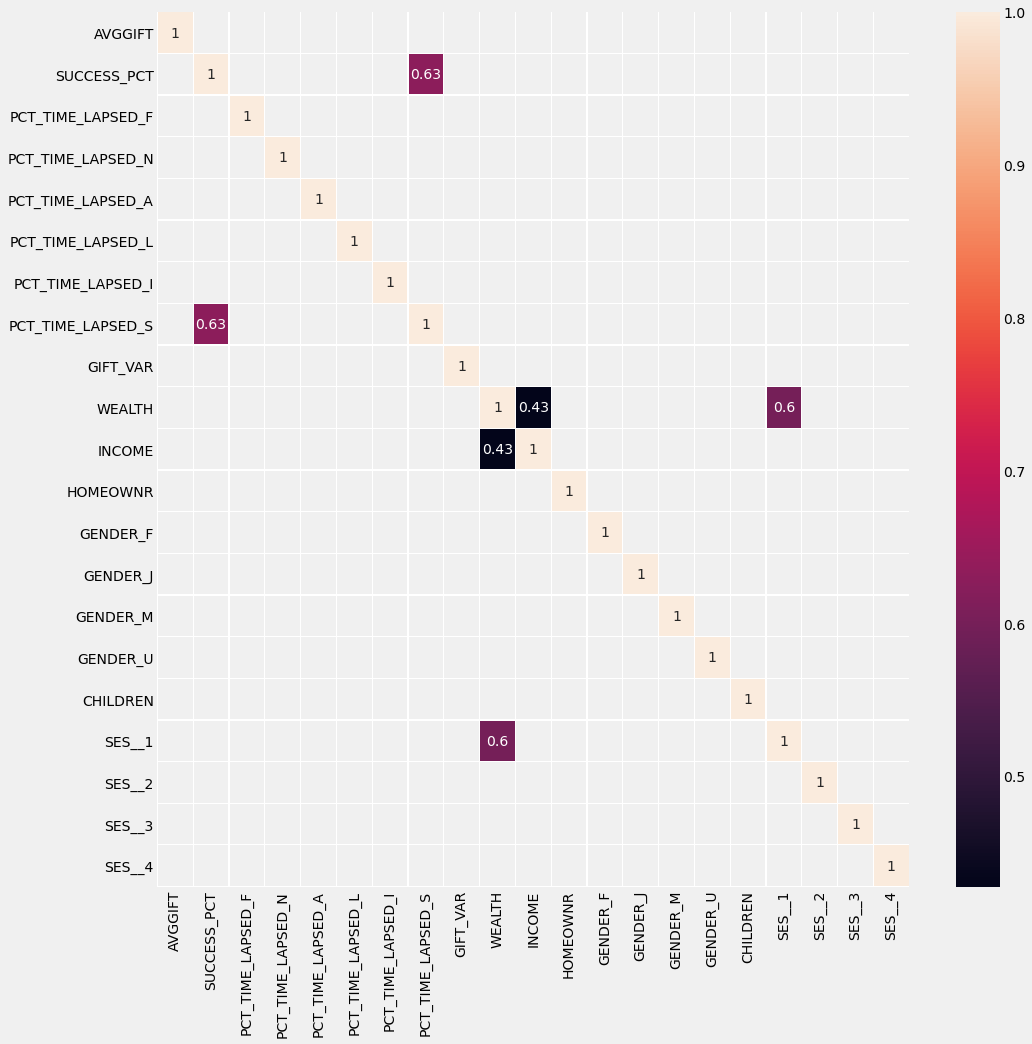

In [255]:
corr = filtered_df.corr()
corr = corr[corr > 0.4]

plt.figure(figsize=(15,15))
sns.heatmap(corr, annot=True, linewidths=0.2)
plt.show()

    overall looking ok

# Clustering

In [307]:
from sklearn.cluster import KMeans
from sklearn.cluster import AffinityPropagation
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import DBSCAN
from sklearn.cluster import Birch

In [257]:
inertia = []
k_range = range(1,15)

In [258]:
for k in k_range:
    k_means = KMeans(n_clusters=k)
    k_means.fit(filtered_df)
    inertia.append(k_means.inertia_)

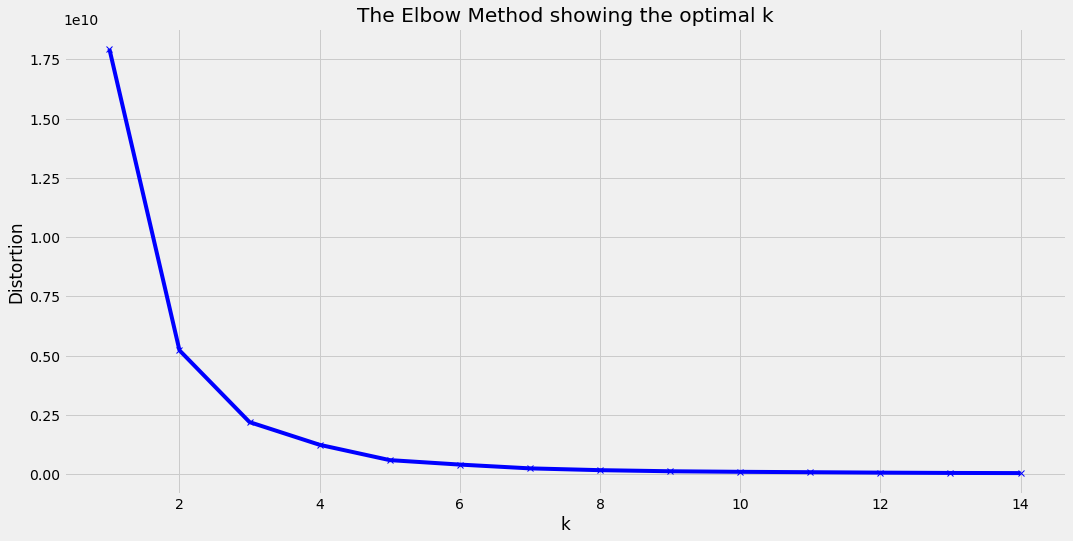

In [259]:
plt.figure(figsize=(16,8))
plt.plot(k_range, inertia, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

In [276]:
from sklearn.feature_selection import VarianceThreshold

k_means = KMeans(n_clusters=3)
k_means.fit(filtered_df)

new_column = 'cluster'

selector = VarianceThreshold()

filtered_df[new_column] = k_means.predict(selector.fit_transform(filtered_df))


selector

VarianceThreshold()

In [277]:
selector.get_support()

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True])

In [278]:
filtered_df.head()

AVGGIFT  SUCCESS_PCT  PCT_TIME_LAPSED_F  PCT_TIME_LAPSED_N  \
1  15.666667     0.093750            0.03125              0.125   
2   7.481481     0.428571            0.00000              0.000   
3   6.812500     0.242424            0.00000              0.000   
4   6.864865     0.327434            0.00000              0.000   
6   7.642857     0.222222            0.00000              0.000   

   PCT_TIME_LAPSED_A  PCT_TIME_LAPSED_L  PCT_TIME_LAPSED_I  PCT_TIME_LAPSED_S  \
1           0.312500           0.062500           0.000000           0.000000   
2           0.000000           0.015873           0.000000           0.285714   
3           0.060606           0.015152           0.000000           0.227273   
4           0.132743           0.044248           0.017699           0.000000   
6           0.126984           0.015873           0.000000           0.174603   

    GIFT_VAR  WEALTH  INCOME  HOMEOWNR  GENDER_F  GENDER_J  GENDER_M  \
1  84.500000     9.0     6.0         1         0         0         1   
2   2.571429     1.0     3.0         0         0         0         1   
3   3.904762     4.0     1.0         0         1         0         0   
4  12.500000     2.0     3.0         1         1         0         0   
6   0.500000     6.0     4.0         1         1         0         0   

   GENDER_U  CHILDREN  SES__1  SES__2  SES__3  SES__4  cluster  
1         0         1       1       0       0       0        0  
2         0         0       0       1       0       0        0  
3         0         0       0       1       0       0        0  
4         0         1       0       1       0       0        0  
6         0         1       0       1       0       0        0

In [345]:
filtered_df.groupby(new_column).mean().transpose()

cluster_affinity           0          1            2
AVGGIFT            10.057891  22.632438    96.055071
SUCCESS_PCT         0.200859   0.122228     0.095048
PCT_TIME_LAPSED_F   0.029340   0.087810     0.044636
PCT_TIME_LAPSED_N   0.046544   0.053466     0.031872
PCT_TIME_LAPSED_A   0.183757   0.165410     0.144225
PCT_TIME_LAPSED_L   0.045234   0.059063     0.048019
PCT_TIME_LAPSED_I   0.002230   0.003956     0.004269
PCT_TIME_LAPSED_S   0.077395   0.023145     0.008124
GIFT_VAR           11.906263  44.154042  1685.858770
WEALTH              5.216172   5.687290     6.604444
INCOME              3.791878   4.251621     4.857778
HOMEOWNR            0.712529   0.742208     0.768889
GENDER_F            0.547130   0.499024     0.453333
GENDER_J            0.004629   0.003437     0.008889
GENDER_M            0.424797   0.477385     0.502222
GENDER_U            0.023444   0.020155     0.035556
CHILDREN            0.287350   0.274041     0.253333
SES__1              0.290751   0.390829     0.488889
SES__2              0.494486   0.434575     0.275556
SES__3              0.176085   0.136161     0.080000
SES__4              0.016160   0.015780     0.000000
cluster             0.000040   0.000156     0.066667

In [330]:
pctimes = ['PCT_TIME_LAPSED_F', 'PCT_TIME_LAPSED_N', 'PCT_TIME_LAPSED_L', 'PCT_TIME_LAPSED_S', 'PCT_TIME_LAPSED_A', 'PCT_TIME_LAPSED_I']
target =  ['AVGGIFT', 'SUCCESS_PCT']
total = pctimes+target

In [342]:
model = KMeans(n_clusters=3)

new_column = 'cluster_affinity'

#selector = VarianceThreshold()

filtered_df[new_column] = model.fit_predict(filtered_df[total])


#filtered_df[new_column] = model.fit_predict(selector.fit_transform(filtered_df.iloc[:,:-1]))


selector.get_support()

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True])

In [343]:
filtered_df['cluster_affinity'].value_counts()

0    49692
1    12801
2      225
Name: cluster_affinity, dtype: int64

In [ ]:
filtered_df

In [305]:
len(pd.Series(model.labels_).unique())

32

In [265]:
figure = boxplot_cluster_compparisson(filtered_df)

In [266]:
figure.savefig('Images/pretty_boxplot.png')